In [1]:
using Revise
using PauliPropagation
using PauliPropagation: _translatetolowestinteger, inttostring, alternatingmask

using Plots

In this notebook, we show how symmetry can be added in Pauli Propagation. 
The basic idea is to merge Pauli strings if they are related by a symmetry. 

#TODO (YT): add reference to arXiv link

### Lowest integer representation (canonical representation)

For instance, consider the following operator:
$$
P = XII + IXI + IIX.
$$
Clearly, the Pauli string $P$ is translational invariant. 
Suppose we can just work with a representative $XII$, then the *effective* Pauli string is:
$$
\tilde{P} = 3 XII.
$$


In [2]:
# Let us define the initial Pauli string
nq = 3
p = PauliSum(nq)
for i in 1:nq
    add!(p, :X, i)
end
println("Initial Pauli string: ", p)

Initial Pauli string: PauliSum(nqubits: 3, 3 Pauli terms:
 1.0 * IXI
 1.0 * IIX
 1.0 * XII
)


First we discuss how to find the representatives. 

Consider the translation symmetru in $1d$, we adopt representatives that are 
given by the lowest integers. 

In [3]:
# To find the representative, we define a function that maps a Pauli string to an integer.
# Consider the second Pauli string:
pstr = PauliString(nq, :X, 2)
# The integer representation is given by:
println("Integer representation of ", pstr, " is ", pstr.term)

# We can then translate the integer to the lowest integer in its symmetry class:
rep_int = _translatetolowestinteger(pstr.term, nq)
println("The representative integer is ", rep_int)

# We can verify that this lowest integer representation corresponds to XII
println("The representative Pauli string is XII: ", PauliString(nq, :X, 1).term)

Integer representation of PauliString(nqubits: 3, 1.0 * IXI) is 4
The representative integer is 1
The representative Pauli string is XII: 1


In [4]:
# To get the effective representation of the original Pauli string, we can do:
translationmerge(p)

PauliSum(nqubits: 3, 1 Pauli term: 
 3.0 * XII
)

As another example, consider the two Pauli strings $XIZI$ and $ZIXI$. 
Their representative is given by the latter because we want the smaller Pauli to be in the higher position and identities as far as possible. 

In [5]:
# Let's verify that is the case:
nq = 4
pstr = PauliString(nq, [:X, :Z], [2, 4])
println("The integer representation of ", pstr, " is ", pstr.term)
println("The lowest integer representation of ", pstr, " is ", _translatetolowestinteger(pstr.term, nq))
pstr = PauliString(nq, [:Z, :X], [1, 3])
println("The integer representation of ", pstr, " is ", pstr.term)  
# println("The lowest integer representation of ", pstr, " is ", _translatetolowestinteger(pstr.term, nq))

The integer representation of PauliString(nqubits: 4, 1.0 * IXIZ) is 196
The lowest integer representation of PauliString(nqubits: 4, 1.0 * IXIZ) is 19
The integer representation of PauliString(nqubits: 4, 1.0 * ZIXI) is 19


We can also apply this in $2d$. It's a bit tricky to visualize a $2d$ Pauli string but we can use the helper function

In [6]:
# Imagine we have a 2x3 lattice with periodic boundary conditions.
# We can represent a Pauli string on this lattice using a 6-qubit Pauli string.
# For example, consider the following Pauli string:
nx, ny = 2, 3
nq = nx * ny
pstr = PauliString(nq, [:X, :Y, :Z], [1, 3, 5])
println("The integer representation of ", pstr, " is ", pstr.term)
# To find its representative under 2D translations, we can use the following helper function:
println("The 2d visualization of ", pstr, " is:" )
println(inttostring(pstr.term, nx, ny))


The integer representation of PauliString(nqubits: 6, 1.0 * XIYIZI) is 801
The 2d visualization of PauliString(nqubits: 6, 1.0 * XIYIZI) is:
XI
YI
ZI



In [7]:
# Now consider another Pauli string that is a translation of the previous one:
pstr2 = PauliString(nq, [:X, :Y, :Z], [2, 4, 6])
println("The integer representation of ", pstr2, " is ", pstr2.term)
println("The 2d visualization of ", pstr2, " is:" )
println(inttostring(pstr2.term, nx, ny))

pstr3 = PauliString(nq, [:Z, :X, :Y], [4, 6, 2])
println("The integer representation of ", pstr3, " is ", pstr3.term)
println("The 2d visualization of ", pstr3, " is:" )
println(inttostring(pstr3.term, nx, ny))

The integer representation of PauliString(nqubits: 6, 1.0 * IXIYIZ) is 3204
The 2d visualization of PauliString(nqubits: 6, 1.0 * IXIYIZ) is:
IX
IY
IZ

The integer representation of PauliString(nqubits: 6, 1.0 * IYIZIX) is 1224
The 2d visualization of PauliString(nqubits: 6, 1.0 * IYIZIX) is:
IY
IZ
IX



In [8]:
# Turns out for 2d finding the lowest integer representation can be speed up 
# by precomputing "masks" for translations in x and y directions. 
# See `_translatetolowestinteger` in the source code for details.
# We will just call the function `translationmerge` here.

# The representative Pauli string is given by
psum = PauliSum([pstr, pstr2, pstr3])
rep_int_2d = translationmerge(psum, nx, ny)

PauliSum(nqubits: 6, 1 Pauli term: 
 3.0 * YIZIXI
)

#### You can also define the merging function for your own symmetry. Let's see an example of this using *permutation symmetry*

We can define the representative of Paulis under permutation symmetry by counting the number of Pauli $X, Y, Z$

In [9]:
function _countbitx(pstr::PauliStringType)

    # super bit mask 
    mask_x = alternatingmask(pstr) # ....1010101 representing XXX...
    mask_y = mask_x << 1  # ...101010 representing YYY...

    # AND with NOT of Y to get only X
    xs = (pstr & mask_x) & ((~pstr & mask_y) >> 1) # Shift right to align

    # count 0 pairs to get the number of X Paulis
    return count_ones(xs)
end

function _countbity(pstr::PauliStringType)

    # super bit mask 
    mask_x = alternatingmask(pstr) # ....1010101 representing XXX...
    mask_y = mask_x << 1  # ...101010 representing YYY...

    # And with NOT of X to get only Y
    op = ((pstr & mask_y) >> 1 ) & (~pstr & mask_x)  # Shift right to align
    # count 1's to get the number of Y Paulis
    return count_ones(op)
end

function _countbitz(pstr::PauliStringType)

    # super bit mask 
    mask_x = alternatingmask(pstr) # ....1010101 representing XXX...
    mask_y = mask_x << 1  # ...101010 representing YYY...

    # AND with both masks to extract the 1's on both bits
    op = ((pstr & mask_y) >> 1 ) & (pstr & mask_x)  

    # count 1's to get the number of Z Paulis
    return count_ones(op)
end

function _permutetocanonicalform(pstr::PauliStringType)
    if pstr == 0
        return pstr
    end

    num_x = _countbitx(pstr)
    num_y = _countbity(pstr)
    num_z = _countbitz(pstr)

    # construct the canonical form PauliString
    pstr_canonical = identitylike(pstr)
    for ii in 1:num_x
        pstr_canonical = setpauli(pstr_canonical, :X, ii)
    end
    for ii in (num_x+1):(num_x+num_y)
        pstr_canonical = setpauli(pstr_canonical, :Y, ii)
    end
    for ii in (num_x+num_y+1):(num_x+num_y+num_z)
        pstr_canonical = setpauli(pstr_canonical, :Z, ii)
    end

    return pstr_canonical
end

_permutetocanonicalform (generic function with 1 method)

In [10]:
# Now define a shorthand for merging under permutation symmetry
permutationmerge(psum::PauliSum) = symmetrymerge(
    psum, (pstr -> _permutetocanonicalform(pstr))
)

permutationmerge (generic function with 1 method)

In [11]:
# Let's see some examples of merging!
pstr1 = PauliString(4, [:X, :Y, :Z], [1, 2, 3])
pstr2 = PauliString(4, [:Y, :Z, :X], [2, 3, 4])
pstr3 = PauliString(4, [:Z, :X, :Y], [1, 3, 4])
psum = PauliSum([pstr1, pstr2, pstr3])
rep_perm = permutationmerge(psum)
println("The representative under permutation symmetry is: ", rep_perm)

The representative under permutation symmetry is: PauliSum(nqubits: 4, 1 Pauli term: 
 3.0 * XYZI
)


### Greedy merging heuristics

There is no unique representative in general, and depending on the strategy, one may even change the representatives throughout the simulation. 

For instance, a greedy merging heuristics was first given by PauliStrings.jl (https://arxiv.org/abs/2410.09654). The strategy is to choose representatives such that the first Pauli is non-identity. 

In [12]:
"""
    greedytranslationshift(pstr::PauliStringType)
Shift a `pstr` to the right until the first non-I Pauli, used for a system with
translational symmetry.
"""        
function greedytranslationshift(pstr::PauliStringType)
    if pstr == 0
        return pstr
    end

    # shift until the first non-zero Pauli
    while getpauli(pstr, 1) == 0
        pstr = PauliPropagation._paulishiftright(pstr)
    end

    return pstr
end

"""
    greedytranslationmerge(psum::PauliSum)
Shift and merge of a `psum` in a system with translational symmetry.
"""
function greedytranslationmerge(psum::PauliSum)
    shifted_psum = PauliPropagation.similar(psum)

    for (pstr, coeff) in psum
        pstr = greedytranslationshift(pstr)
        add!(shifted_psum, pstr, coeff)
    end

    return shifted_psum
end



greedytranslationmerge

Now we will evolve a Pauli string under translational invariant Hamiltonian 
and we will try it out using greedy merging

In [13]:
# Build evolution angles for TFIM model
function get_tfim_couplings(circuit, deltat::Float64; J=1, hz=0.9045, hx=1.4)
    thetas = []

    indices_gate_zz = getparameterindices(circuit, PauliRotation, [:Z, :Z])
    indices_gate_x = getparameterindices(circuit, PauliRotation, [:X])
    indices_gate_z = getparameterindices(circuit, PauliRotation, [:Z])

    for (idx, gate) in enumerate(circuit)

        if idx in indices_gate_zz
            coupling_strength = - deltat * J
        elseif idx in indices_gate_x
            coupling_strength = - deltat * hx
        elseif idx in indices_gate_z
            coupling_strength = - deltat * hz
        else
            throw(ArgumentError("Gate at index $idx is neither ZZ, X nor Z rotation"))
        end
        push!(thetas, coupling_strength * 2) # e^i t P / 2 * 2
    end
            
    return thetas
end

# Define time evolution function
"""
Perform Pauli propagation with symmetric merging.

Args:
    circuit: The circuit to be applied.
    p_init: The operator to be propagated.
    thetas: The angles for the Trotter steps.


Returns:
    p_propagated: The evolved operator; correlation_matrix: ccorrelation matrix.
"""
function symmetric_pauli_propagation(
    nq::Int,
    p_init::PauliSum;
    nl::Int=1,
    max_weight=Inf,
    min_abs_coeff=0.,
    customtruncationfunction=nothing,
    deltat=0.25,
    periodic=true,
    circuit = tiltedtfitrottercircuit,
    topology=bricklayertopology,
    gx=1.4,
    gz=0.9045,
    merging=:full
)
    circ = circuit(nq, 1; topology=topology(nq, periodic=periodic))
    thetas = get_tfim_couplings(circ, deltat; J=1, hz=gz, hx=gx)
    
    p_propagated = p_init

    # nl = maximum(layers)
    for i in 1:nl
        # Pauli propagation for a single Trotter step
        p_propagated = propagate(
            circ, p_propagated, thetas; max_weight=max_weight, 
            min_abs_coeff=min_abs_coeff,
            customtruncationfunction=customtruncationfunction
        )
        
        # Perform symmetry merging
        if merging == :full
            p_propagated = translationmerge(p_propagated)
        elseif merging == :greedy
            p_propagated = greedytranslationmerge(p_propagated)
        elseif merging == :none
            # do nothing
        else
            error("Merging method $(merging) not recognized.")
        end
    end

    return p_propagated
end

symmetric_pauli_propagation

In [18]:
# Now we run the evolution with different merging strategies under tilted-field Ising model
nq = 11
layers = [3, 5]
strategies = [:none, :greedy, :full]
pstr = PauliString(nq, :Z, div(nq, 2) + 1)

results = []
for merging in strategies

    p_evolved = PauliSum(pstr)

    for (i, l) in enumerate(layers)
        p_evolved = symmetric_pauli_propagation(
            nq, p_evolved; nl=(i > 1 ? (l - layers[i-1]) : l),
            merging=merging
        )
        push!(results, (merging=merging, nl=l, p_evolved=p_evolved, nterms=length(p_evolved)))
    end
end

Let's plot the operators as image:

- x-axis labels qubit indices
- y-axis labels different Pauli strings: dark blue means non-I and light-blue means I

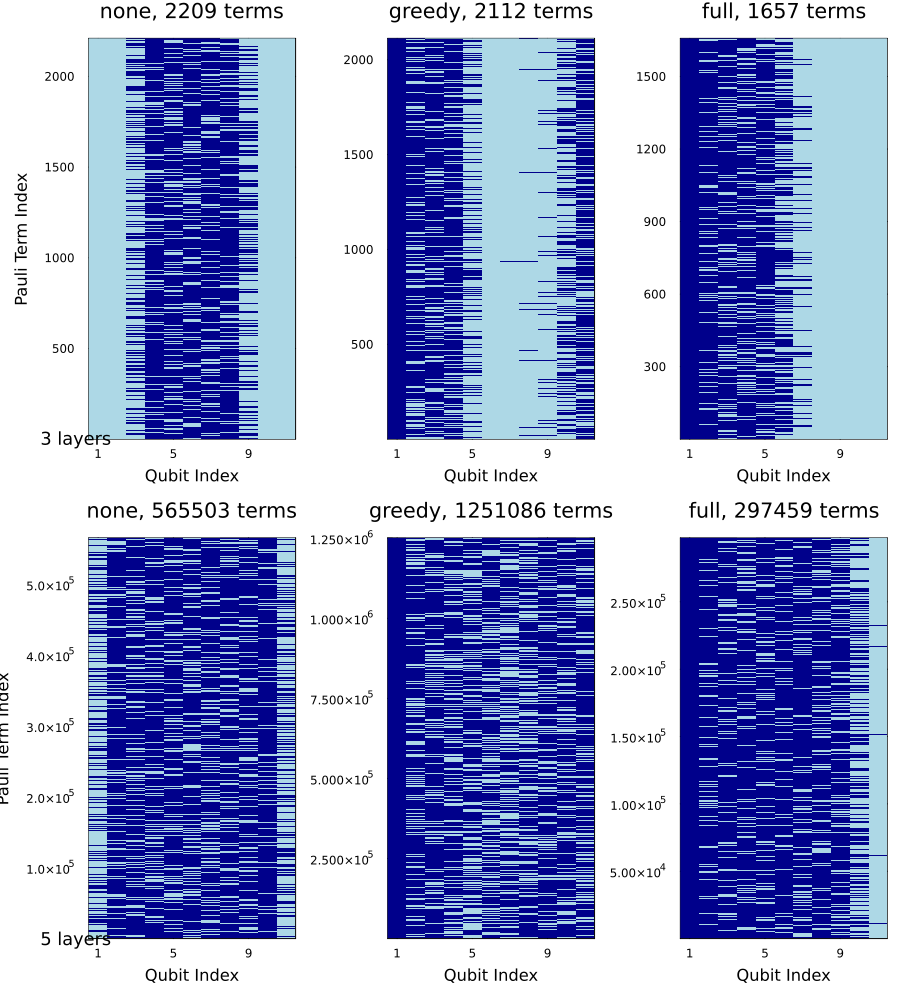

In [19]:
gr()

# Mapping Pauli to fill level
pauli_map = Dict('I'=>0, 'X'=>1, 'Y'=>1, 'Z'=>1)

ncols = length(strategies)       # number of merging strategies
nrows = length(layers)                  # number of layers

rows = ["$(l) layers" for l in layers]

# Layout: Plots.jl uses column-major order!!
fig = plot(layout = (nrows, ncols), size=(300*ncols, 500*nrows), framestyle=:box)

# Plot array with nl as rows and merging methods as columns
# Plot `heatmap` with x axis as qubit index and y axis as Pauli term index
for (col, merging) in enumerate(strategies)
    for (row, nl) in enumerate(layers)
    
        # position in column-major layout
        cell = (row - 1) * ncols + col

        # Filter the right entry in results=(merging, nl, p_evolved)
        idx = findfirst(r -> r.merging == merging && r.nl == nl, results)
        entry = results[idx]        
        
        psum = entry.p_evolved.terms
        # Extracting the data for the heatmap
        data = zeros(length(psum), nq)

        for (k, (pauli, coeff)) in enumerate(psum)
            pauli_str = inttostring(pauli, nq)

            for (q, p) in enumerate(pauli_str)
                data[k, q] = pauli_map[p]
            end
        end

        heatmap!(
            fig,
            data,
            color = :blues,
            aspect_ratio = :auto,
            subplot = cell,
            title = "$(merging), $(length(psum)) terms",
            xlabel = "Qubit Index",
            xticks = 1:4:nq,
            ylabel = (col == 1 ? "Pauli Term Index" : ""),
            colorbar = false,  # disable individual colorbars
            margin = 1Plots.mm  # Reduce subplot margins if needed
        )
   
    end
end

# ---- Row labels (annotations on left) ----
pad = 10
for (i, row_label) in enumerate(rows)
    # Use annotate! on the corresponding subplot
    annotate!(fig[1 + (i-1)* ncols], -2, 5, text(row_label, :left, 12))
end

display(fig)


Observe how in this example greedy approach generates a lot more Paulis at layer 5!
Thought eventually when Pauli strings saturate the full operator space, the number of Pauli strings will be reduced again. Notice full symmetry merging gaurantees the least number of Paulis as promised :)